In [1]:
!python3 --version

Python 3.5.2


In [2]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt

def GetImagePath(sub, sess, frame):
    """
    Function: get image path name according to the inputs
    """
    # read the image path
    folder_name = "sub" + str(sub) + "_session" + str(sess)
    image_path = folder_name + "/" + folder_name + "_frame" + str(frame) + ".png"
    
    return image_path

def ReadImage(image_path):
    """
    Function:
        Read and resize images with specific subname, session name and frame name.
    """
    # read the image
    image = imread(image_path)
    # resize the image
    output_size = (64, 64)
    image = resize(image, output_size)
    
    return image


# define all the sub names, session names, and frame names into np.array
sub_names_train = np.arange(1, 11)
sub_names_test = np.concatenate([np.arange(31, 39), np.array([40])], axis = -1)
session_names = np.arange(1, 3)
frame_names_train = np.arange(1, 24)
frame_names_test = np.arange(1, 25)

# image examples, for visualization and some tests
# same faces
path_example_1 = GetImagePath(sub_names_train[0], session_names[0], frame_names_train[0])
image_example_1 = ReadImage(path_example_1)
path_example_2 = GetImagePath(sub_names_train[0], session_names[1], frame_names_train[0])
image_example_2 = ReadImage(path_example_2)
path_example_3 = GetImagePath(sub_names_train[0], session_names[0], frame_names_train[10])
image_example_3 = ReadImage(path_example_3)
path_example_4 = GetImagePath(sub_names_train[0], session_names[0], frame_names_train[22])
image_example_4 = ReadImage(path_example_4)
# different faces
path_example_5 = GetImagePath(sub_names_train[1], session_names[0], frame_names_train[0])
image_example_5 = ReadImage(path_example_5)
path_example_6 = GetImagePath(sub_names_train[5], session_names[0], frame_names_train[5])
image_example_6 = ReadImage(path_example_6)
path_example_7 = GetImagePath(sub_names_test[5], session_names[0], frame_names_test[22])
image_example_7 = ReadImage(path_example_7)

# print out the shape of the image
print("Image shape is: \t", image_example_1.shape)

# same faces test
fig = plt.figure()
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.imshow(image_example_1)
ax2.imshow(image_example_2)
ax3.imshow(image_example_3)
ax4.imshow(image_example_4)
plt.show()

# different faces test
fig = plt.figure()
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)
ax1.imshow(image_example_1)
ax2.imshow(image_example_5)
ax3.imshow(image_example_6)
ax4.imshow(image_example_7)
plt.show()


/home/azhang/.local/lib/python3.5/site-packages/matplotlib/__init__.py:1038: UserWarning: Bad val "GTKAgg" on line #1
	"backend: GTKAgg
"
	in file "/home/azhang/.config/matplotlib/matplotlibrc"
	Key backend: Unrecognized backend string 'gtkagg': valid strings are ['WebAgg', 'ps', 'Qt4Cairo', 'GTK3Agg', 'pdf', 'MacOSX', 'TkCairo', 'Qt5Agg', 'WXCairo', 'cairo', 'Qt5Cairo', 'TkAgg', 'WX', 'nbAgg', 'svg', 'Qt4Agg', 'GTK3Cairo', 'WXAgg', 'pgf', 'template', 'agg']
  (val, error_details, msg))


Image shape is: 	 (64, 64, 3)


<Figure size 640x480 with 4 Axes>

<Figure size 640x480 with 4 Axes>

In [3]:

def NormalizedCrossCorrelation(image1, image2):
    """
    Funtion: calculating normalized cross correlation (NCC) between two images
    """
    numerator = np.sum((image1 - np.mean(image1)) * (image2 - np.mean(image2)))
    denominator = np.sqrt(np.sum(np.square(image1 - np.mean(image1))) * \
                          np.sum(np.square(image2 - np.mean(image2))))
    return numerator / denominator

def CrossCorrelation(image1, image2):
    """
    Function: original cross correlation between two images
    """
    return np.sum((image1 - image1.mean()) * (image2 - image2.mean()))

def Convolution(image1, image2):
    """
    Funtion: calculating convolution between two images
    """
    return np.sum(np.flip((image1 - image1.mean())) * image2)

def SumSquareDifferences(image1, image2):
    """
    Funtion: calculating pixel differences between two images
    """
    return np.sum(np.square(image1 - image2))

def CompareAllTricks(image1, image2):
    """
    Function: compare the scores w.r.t 3 methods and choose the best one
    """
    a = NormalizedCrossCorrelation(image1, image2)
    b = Convolution(image1, image2)
    c = SumSquareDifferences(image1, image2)
    return [a, b, c]

# try differences betwwen correlation, convolution and squared differences
# try with same faces but different illumination
compare_example_1 = CompareAllTricks(image_example_1, image_example_2)
compare_example_2 = CompareAllTricks(image_example_1, image_example_3)
compare_example_3 = CompareAllTricks(image_example_1, image_example_4)
# try with different faces with different illumination
compare_example_4 = CompareAllTricks(image_example_1, image_example_5)
compare_example_5 = CompareAllTricks(image_example_1, image_example_6)
compare_example_6 = CompareAllTricks(image_example_1, image_example_7)

print("---------------------------------- same faces ------------------------------------")
print("NCC:{} \t \t \t Conv:{} \t SSD:{}".format(compare_example_1[0], compare_example_1[1], compare_example_1[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_2[0], compare_example_2[1], compare_example_2[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_3[0], compare_example_3[1], compare_example_3[2]))
print("------------------------------- different faces ----------------------------------")
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_4[0], compare_example_4[1], compare_example_4[2]))
print("NCC:{} \t \t Conv:{} \t SSD:{}".format(compare_example_5[0], compare_example_5[1], compare_example_5[2]))
print("NCC:{} \t Conv:{} \t SSD:{}".format(compare_example_6[0], compare_example_6[1], compare_example_6[2]))


---------------------------------- same faces ------------------------------------
NCC:1.0 	 	 	 Conv:84.91780926074851 	 SSD:0.0
NCC:0.7177882918040279 	 	 Conv:34.39739781668252 	 SSD:266.91643021914643
NCC:0.6618261099181423 	 	 Conv:27.32804301155204 	 SSD:294.1769127258746
------------------------------- different faces ----------------------------------
NCC:0.5338608734949605 	 	 Conv:60.85439800187653 	 SSD:163.69754036908876
NCC:0.2861959200424425 	 	 Conv:17.488654840536064 	 SSD:252.9331487889273
NCC:0.38768792843956684 	 Conv:20.040709458482795 	 SSD:236.74956843521716


In [4]:
import os
from tqdm import tqdm

# setting NCC threshold according to the experiment above
def ClassifyAndSave(im1_path, im2_path):
    """
    Function: 
        find out whether two image show the same face and save the dataset
    """
    # read images
    image1 = ReadImage(im1_path)
    image2 = ReadImage(im2_path)
    # find pair scores
    NCC_score = NormalizedCrossCorrelation(image1, image2)
    
    return [im1_path, im2_path, str(NCC_score)]

def GetAllImagePathes(sub_names, session_names, frame_names):
    """
    Function: get all image pathes from the specific subsets
    """
    # subset 35 and subset 37 have no session 2
    sub_no_sess2_test = np.array([35, 37])
    # store pathes
    all_images_pathes = []
    for i in range(len(sub_names)):
        sub = sub_names[i]
        if sub in sub_no_sess2_test:
            sess_len = len(session_names) - 1
        else:
            sess_len = len(session_names)
        for j in range(sess_len):
            sess = session_names[j]
            for k in range(len(frame_names)):
                frame = frame_names[k]
                image_path = GetImagePath(sub, sess, frame)
                all_images_pathes.append(image_path)
                
    return all_images_pathes

def LoopOverEachPair(all_train_im_path):
    """
    Function:
        loop over each pair of images, find labels, and save them
    """
    # loop over each pair, define the label and save as data.txt file
    data = []
    dataset_file = open("data.txt", "w+")
    with tqdm(total=460) as pbar:
        while len(all_train_im_path) > 0:
            current_image_path = all_train_im_path[0]
            all_train_im_path.remove(current_image_path)
            for another_img_path in all_train_im_path:
                data = ClassifyAndSave(current_image_path, another_img_path)
                dataset_file.write(data[0] + "," + data[1] + "," + data[2] + "," + "\n")
            pbar.update(1)

def CreatDataset():
    """
    Function:
        create the dataset.
    """
    # get all training image pathes
    all_train_im_path = GetAllImagePathes(sub_names_train, session_names, frame_names_train)
    print("There are totally ", len(all_train_im_path), " training images.")

    # get dataset and save it into a data.txt file
    print("------------- starting storing dataset -------------")
    LoopOverEachPair(all_train_im_path)
    print("-------------- end of storing dataset --------------")
    

# read the saved data.txt, if exits and contains all data, skip the annotation part
if os.path.exists('data.txt'):
    statinfo = os.stat('data.txt')
    # get size as MB
    exist_dataset_size = statinfo.st_size / 1024 / 1024
    # total size is around 8 MB
    if exist_dataset_size > 8:
        print("------------------------ dataset already exists -------------------------")
    else:
        CreatDataset()
else:
    CreatDataset()


------------------------ dataset already exists -------------------------


In [5]:

def ReadDatasetTxt(data_filename, NCC_threshold):
    """
    Function:
        read the dataset saved above, to find out some
        basical info about the dataset.
    """
    data_file = open(data_filename, "r")
    same_faces = []
    diff_faces = []
    for line in data_file:
        current_line = line.split(",")
        # find out it is same faces pair or different faces pair
        if float(current_line[2]) > NCC_threshold:
            same_faces.append([current_line[0], current_line[1], str(1)])
        else:
            diff_faces.append([current_line[0], current_line[1], str(0)])
    data_file.close()
    return same_faces, diff_faces

# setting threshold for same faces
NCC_threshold = 0.66
data_f_name = "data.txt"
same_faces, diff_faces = ReadDatasetTxt(data_f_name, NCC_threshold)

print("There are totally ", len(same_faces) + len(diff_faces), " pairs of images inside the datset,")
print("With ", len(same_faces), " pairs showing same faces,")
print("And ", len(diff_faces), " pairs showing different faces,")


There are totally  105570  pairs of images inside the datset,
With  24770  pairs showing same faces,
And  80800  pairs showing different faces,


label of this pair is: 	 different faces


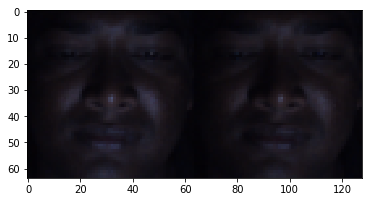

label of this pair is: 	 different faces


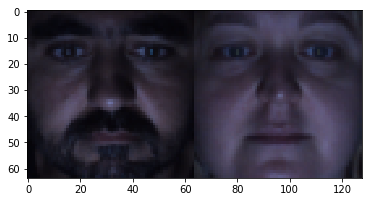

In [6]:

def PlotAndVerifyRandomPair(dataset):
    """
    Function: 
        plot random pair images with the label to verify the datset is set
    right or wrong.
    """
    # select a random index
    ind = np.random.randint(len(dataset))
    # read image pair
    img1 = ReadImage(dataset[ind][0])
    img2 = ReadImage(dataset[ind][1])
    # read label
    label = float(dataset[ind][2])
    if label > 1:
        label_show = "same face"
    else:
        label_show = "different faces"
    # plot images
    display_imgs = np.concatenate([img1, img2], axis = 1)
    print("label of this pair is: \t", label_show)
    plt.imshow(display_imgs)
    plt.show()
    
PlotAndVerifyRandomPair(same_faces)
PlotAndVerifyRandomPair(diff_faces)
    

In [7]:
import random

def CreateTrainAndValidationSet(same_faces, diff_faces, validation_rate = 0.01):
    """
    Function:
        Shuffle the dataset and separate the dataset into training set and 
    validation set
    """
    # backup the data for shuffling
    same_faces_shuf = same_faces
    diff_faces_shuf = diff_faces
    # define number of validation data w.r.t each class
    same_validate_num = int(len(same_faces) * validation_rate)
    diff_validate_num = int(len(diff_faces) * validation_rate)
    # get shuffled data
    random.shuffle(same_faces_shuf)
    random.shuffle(diff_faces_shuf)
    # define training and validation set
    valid_set = same_faces_shuf[:same_validate_num] + diff_faces_shuf[:diff_validate_num]
    train_set = same_faces_shuf[same_validate_num:] + diff_faces_shuf[diff_validate_num:]
    # shuffle the training set and validation set again
    random.shuffle(train_set)
    random.shuffle(valid_set)
    return train_set, valid_set

train_set_pathes, valid_set_pathes = CreateTrainAndValidationSet(same_faces, diff_faces)

print("Size of training set is: \t", len(train_set_pathes))
print("Size of validation set is: \t", len(valid_set_pathes))


Size of training set is: 	 104515
Size of validation set is: 	 1055


In [ ]:
##### set specific gpu #####
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
##### start other dependencies #####
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

def GetInputAndOutput(data_pathes):
    """
    Function:
        get all input data and labels
    """
    inputs = []
    labels = []
    # get every data in each batch
    for i in range(len(data_pathes)):
        current_data = data_pathes[i]
        # read images (resized)
        img1 = ReadImage(current_data[0])
        img2 = ReadImage(current_data[1])
        # concatenate images
        img_concat = np.concatenate([img1, img2], axis = 0)
        # reshape input data
        each_input = img_concat.reshape((-1,))
        # get label as one hot format
        label_ind = int(current_data[2])
        label = np.zeros((2,)).astype(np.float32)
        label[label_ind] = 1.
        # orgnizing input and output
        inputs.append(each_input)
        labels.append(label)
    inputs = np.array(inputs)
    labels = np.array(labels)
    return (inputs, labels)

def InputAndOutputGenerator(data_pathes, batch_size = 10):
    """
    Function:
        Since when transfer into images, dataset is too big to read it all at once, a generator
    is created to generate the data according to the batch_size
    """
    # get number of batches
    num_batch = len(data_pathes) // batch_size
    for batch_id in range(num_batch):
        # get batch data
        data_path_batch = data_pathes[batch_id*batch_size: (batch_id+1)*batch_size]
        batch_inputs = []
        batch_labels = []
        # get every data in each batch
        for i in range(len(data_path_batch)):
            current_data = data_path_batch[i]
            # read images (resized)
            img1 = ReadImage(current_data[0])
            img2 = ReadImage(current_data[1])
            # concatenate images
            img_concat = np.concatenate([img1, img2], axis = 0)
            # reshape input data
            each_input = img_concat.reshape((-1,))
            # get label as one hot format
            label_ind = int(current_data[2])
            label = np.zeros((2,)).astype(np.float32)
            label[label_ind] = 1.
            # orgnizing input and output
            batch_inputs.append(each_input)
            batch_labels.append(label)
        batch_inputs = np.array(batch_inputs)
        batch_labels = np.array(batch_labels)
        yield (batch_inputs, batch_labels)

def MLPModel():
    """
    Building the MLP model
    """
    model = Sequential()
    # structure: (batch, 128*64*3) -> (batch, 1024) -> (batch, 256) -> (batch, 64) -> (batch, 10)
    model.add(Dense(units = 256, activation = "relu", input_dim = 128 * 64 * 3))
    model.add(Dense(units = 64, activation = "relu"))
    model.add(Dense(units = 2, activation = "softmax"))
    # using cross entropy as loss and adam as optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

# define model.fit_generator parameters.
batch_size = 100
num_batch_train = len(train_set_pathes) // batch_size
num_batch_valid = len(valid_set_pathes) // batch_size

# get validation set first
validation_set = GetInputAndOutput(valid_set_pathes)
print(validation_set[0].shape)

# set tensorboard
logging = TensorBoard(log_dir="./logs/trial_1", batch_size = batch_size)

# get model
model = MLPModel()
# training and validating with generator
model.fit_generator(InputAndOutputGenerator(train_set_pathes, batch_size),
                    steps_per_epoch=num_batch_train,
                    validation_data=validation_set,
                    epochs=10,
                    callbacks = [logging]
                    )


# for i in InputAndOutputGenerator(train_set_pathes, batch_size):
#     print(i[0].shape)
#     print(i[1].shape)


(1055, 24576)
Epoch 1/10
 114/1045 [==>...........................] - ETA: 32:48 - loss: 0.4973 - acc: 0.7746

In [ ]:
import re

def TestAnnotate(img1_path, img2_path):
    """
    Function:
        Get the annotation of the test set.
    Principle:
        If two images belong to the same subset, they are showing the same face.
    """
    # find the subset number
    img1_sub_searcher = re.search("\d", img1_path)
    img2_sub_searcher = re.search("\d", img2_path)
    img1_sub_ind = int(img1_path[img1_sub_searcher.start()])
    img2_sub_ind = int(img2_path[img2_sub_searcher.start()])
    # compare subset number
    if img1_sub_ind == img2_sub_ind:
        label = 1
    else:
        label = 0
    return [img1_path, img2_path, str(label)]
    

def TestSetLoop(all_test_im_path):
    """
    Function:
        loop over each pair of test images, define labels, and save them
    """
    data = []
    dataset_file = open("data_test.txt", "w+")
    with tqdm(total=len(all_test_im_path)) as pbar:
        while len(all_test_im_path) > 0:
            current_image_path = all_test_im_path[0]
            all_test_im_path.remove(current_image_path)
            for another_img_path in all_test_im_path:
                data = TestAnnotate(current_image_path, another_img_path)
                dataset_file.write(data[0] + "," + data[1] + "," + data[2] + "," + "\n")
            pbar.update(1)

def CreateTestSet():
    """
    Function:
        create the test set file
    """
    all_test_im_path = GetAllImagePathes(sub_names_test, session_names, frame_names_test)
    print("There are totally ", len(all_test_im_path), " testing images.")

    # get dataset and save it into a data.txt file
    print("------------- starting storing dataset (test) -------------")
    TestSetLoop(all_test_im_path)
    print("-------------- end of storing dataset (test) --------------")
    
    
# read the saved data_test.txt, if exits and contains all data, skip the annotation part
if os.path.exists('data_test.txt'):
    testinfo = os.stat('data_test.txt')
    # get size as MB
    exist_testset_size = testinfo.st_size / 1024 / 1024
    # total size is around 6 MB
    if exist_testset_size > 6:
        print("------------------------ dataset already exists -------------------------")
    else:
        CreateTestSet()
else:
    CreateTestSet()
    


In [ ]:
import re

m = re.search("\d", string)

m.start()

In [ ]:
import random

a = [["1", "2", "3"], ["4", "5", "6"], ["7", "8", "9"], ["10", "11", "12"]]

print(a)

random.shuffle(a)

print(a)